# OIH Queries 

What follows are some example SPARQL queries used in OIH for the test interface


## Setup and inits

### Imports

In [1]:
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import dask, boto3
import dask.dataframe as dd
import numpy as np
import json
import geopandas
import matplotlib.pyplot as plt
import shapely
# import kglab as kg

oih = "https://ts.collaborium.io/blazegraph/namespace/oih/sparql"
oihdev = "https://ts.collaborium.io/blazegraph/namespace/development/sparql"
oihinvemar = "https://ts.collaborium.io/blazegraph/namespace/invemar/sparql"
oihad = "https://graph.collaborium.io/blazegraph/namespace/aquadocs/sparql"

### Support Functions

In [2]:
#@title
def get_sparql_dataframe(service, query):
    """
    Helper function to convert SPARQL results into a Pandas data frame.
    """
    sparql = SPARQLWrapper(service)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']

    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)

## Queries

What follows is a set of queries designed to provide a feel for the OIH graph

### Simple Count

How many triples are there?

In [3]:
rq_count = """SELECT (COUNT(*) as ?Triples) 
WHERE 
  {
      { ?s ?p ?o } 
  }
"""

In [4]:
dfsc = get_sparql_dataframe(oihdev, rq_count)
dfsc.head()

,Triples
0,6691593


## Simple org list


In [5]:
rq_orgs = """SELECT (COUNT(*) as ?Triples) 
WHERE 
  {
      { ?s ?p ?o } 
  }
"""

In [6]:
dfsc = get_sparql_dataframe(oihdev, rq_orgs)
dfsc.head()

,Triples
0,6691593


### Predicate Counts

This gives an overview of unique predicates that connect a subject to an object.  This gives us both an idea of the properties we are using on things and count of their usage.


In [7]:
rq_pcount = """SELECT ?p (COUNT(?p) as ?pCount)
WHERE
{
  ?s ?p ?o .
}
GROUP BY ?p
"""

In [8]:
dfc = get_sparql_dataframe(oihdev, rq_pcount)
dfc['pCount'] = dfc["pCount"].astype(int) # convert count to int
# dfc.set_index('p', inplace=True)

In [9]:
dfc_sorted = dfc.sort_values('pCount', ascending=False)
dfc_sorted.head(10)

,p,pCount
66,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,1644273
10,https://schema.org/keywords,811158
2,https://schema.org/name,703830
4,https://schema.org/url,411862
5,https://schema.org/author,324919
0,https://schema.org/description,285497
1,https://schema.org/identifier,176347
19,http://www.w3.org/ns/prov#value,175158
48,https://schema.org/knowsAbout,136063
3,https://schema.org/propertyID,131963


In [10]:
rcount = len(dfc_sorted)
print(rcount)

68


In [11]:
ts = dfc_sorted.tail(38)['pCount'].sum()
print(ts)

366948


In [12]:
hs = dfc_sorted.head(10)
hs.append({'p':'Other','pCount':ts}, ignore_index=True) 
hs.set_index('p', inplace=True)
hs.head(10)

,pCount
p,
http://www.w3.org/1999/02/22-rdf-syntax-ns#type,1644273
https://schema.org/keywords,811158
https://schema.org/name,703830
https://schema.org/url,411862
https://schema.org/author,324919
https://schema.org/description,285497
https://schema.org/identifier,176347
http://www.w3.org/ns/prov#value,175158
https://schema.org/knowsAbout,136063


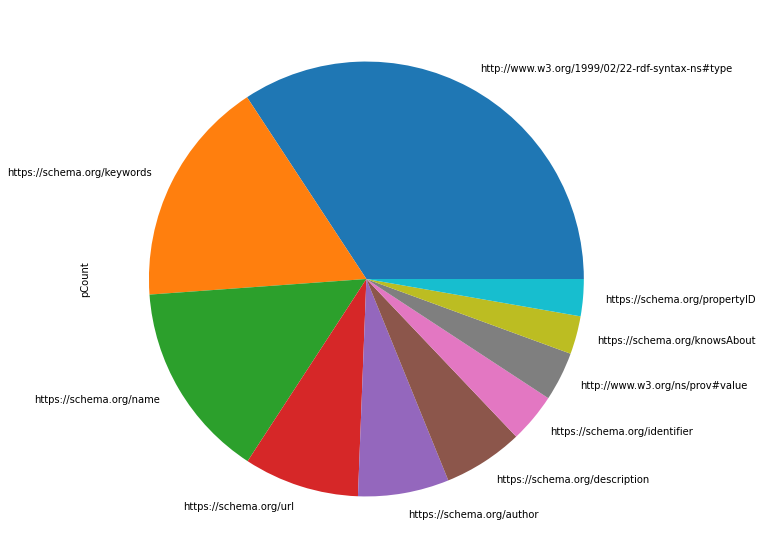

In [13]:
plot = hs.plot.pie(y='pCount',x='p',legend=False, figsize=(10, 10))

### OIH Base Query

In [14]:
rq_main = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

        SELECT DISTINCT ?g  ?s   ?type ?score ?name ?url ?lit ?description ?headline
        WHERE
        {
           ?lit bds:search "coral" .
           ?lit bds:matchAllTerms "false" .
           ?lit bds:relevance ?score .
           graph ?g {
            ?s ?p ?lit .
            ?s rdf:type ?type . 
            OPTIONAL { ?s schema:name ?name .   }
            OPTIONAL { ?s schema:headline ?headline .   }
            OPTIONAL { ?s schema:url ?url .   }
            OPTIONAL { ?s schema:description ?description .    }
          }

        }
        ORDER BY DESC(?score)
        LIMIT 30
        OFFSET 0
        """

In [15]:
df = get_sparql_dataframe(oihdev, rq_main)
df.head(5)

,g,s,type,score,name,url,lit,description,headline
0,urn:gleaner:summoned:aquadocs:5d5193e7e253bbb1...,oai:aquadocs.org:1834/20085,https://schema.org/CreativeWork,1.0,M/V WELLWOOD Coral Reef Restoration Monitoring...,https://www.oceandocs.org/handle/1834/20085,Coral,- This document presents the results of the f...,None
1,urn:gleaner:summoned:aquadocs:5d5193e7e253bbb1...,oai:aquadocs.org:1834/36645,https://schema.org/CreativeWork,1.0,Study of biotic communities for artificial ree...,https://www.oceandocs.org/handle/1834/36645,Coral,- Persian Gulf waters (Hormuzgan Province) we...,None
2,urn:gleaner:summoned:aquadocs:5d5193e7e253bbb1...,oai:aquadocs.org:1834/20119,https://schema.org/CreativeWork,1.0,M/V JACQUELYN L Coral Reef Restoration Monitor...,https://www.oceandocs.org/handle/1834/20119,Coral,- This document presents the results of the m...,None
3,urn:gleaner:summoned:aquadocs:5d5193e7e253bbb1...,oai:aquadocs.org:1834/3262,https://schema.org/CreativeWork,1.0,Los corales (Anthozoa e Hidrozoa) de la bahÃ­a...,https://www.oceandocs.org/handle/1834/3262,Coral,- En el presente trabajo se describe las form...,None
4,urn:gleaner:summoned:aquadocs:5d5193e7e253bbb1...,oai:aquadocs.org:1834/3317,https://schema.org/CreativeWork,1.0,Occurrence and Distribution of Stony Corals (A...,https://www.oceandocs.org/handle/1834/3317,Coral,- Un reconocimiento en los alrededores de San...,None


### OIH Gleaner Query

In [16]:
rq_maingl = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

        SELECT DISTINCT ?g  ?s  ?wat ?orgname ?domain ?type ?score ?name ?url ?lit ?description ?headline
        WHERE
        {
           ?lit bds:search "coral" .
           ?lit bds:matchAllTerms "false" .
           ?lit bds:relevance ?score .
           graph ?g {
            ?s ?p ?lit .
            ?s rdf:type ?type . 
            OPTIONAL { ?s schema:name ?name .   }
            OPTIONAL { ?s schema:headline ?headline .   }
            OPTIONAL { ?s schema:url ?url .   }
            OPTIONAL { ?s schema:description ?description .    }
          }
           ?sp prov:generated ?g  .
           ?sp prov:used ?used .
           ?used prov:hadMember ?hm .
           ?hm prov:wasAttributedTo ?wat .
           ?wat rdf:name ?orgname .
           ?wat rdfs:seeAlso ?domain
        }
        ORDER BY DESC(?score)
        LIMIT 30
        OFFSET 0
        """

In [17]:
df = get_sparql_dataframe(oihdev, rq_maingl)
df.head(5)

,g,s,wat,orgname,domain,type,score,name,url,lit,description,headline
0,urn:gleaner.oih:milled:obis:4e473923c875ed7bbd...,t1811501,https://www.re3data.org/repository/obis,Ocean Biodiversity Information System,https://obis.org,https://schema.org/Dataset,1.0,Coral Reef Evaluation and Monitoring Project F...,https://obis.org/dataset/66f21b70-3a41-4e6d-b3...,coral,The purpose of the Coral Reef Evaluation and M...,None
1,urn:gleaner.oih:milled:obis:51c1b6cb0a8dd0f7d7...,t1811927,https://www.re3data.org/repository/obis,Ocean Biodiversity Information System,https://obis.org,https://schema.org/Dataset,1.0,Coral Reef Evaluation and Monitoring Project D...,https://obis.org/dataset/a90912f8-33de-4725-80...,coral,The purpose of the Coral Reef Evaluation and M...,None
2,urn:gleaner.oih:milled:obis:5303691816051c7c8c...,t1812051,https://www.re3data.org/repository/obis,Ocean Biodiversity Information System,https://obis.org,https://schema.org/Dataset,1.0,Coral Reef Evaluation and Monitoring Project F...,https://obis.org/dataset/aaacf13e-a138-4b75-ba...,coral,The purpose of the Coral Reef Evaluation and M...,None
3,urn:gleaner.oih:milled:obis:58a90ddb672159cd87...,t1812697,https://www.re3data.org/repository/obis,Ocean Biodiversity Information System,https://obis.org,https://schema.org/Dataset,1.0,Coral Reef Evaluation and Monitoring Project F...,https://obis.org/dataset/320bc4a4-e0ee-493b-b4...,coral,The purpose of the Coral Reef Evaluation and M...,None
4,urn:gleaner.oih:milled:obis:5a824c072df459f20f...,t1812883,https://www.re3data.org/repository/obis,Ocean Biodiversity Information System,https://obis.org,https://schema.org/Dataset,1.0,Coral Reef Evaluation and Monitoring Project D...,https://obis.org/dataset/ef941346-7846-48fb-bf...,coral,The purpose of the Coral Reef Evaluation and M...,None


## Query for prov

Count (count(distinct ?tag) as ?count) 

Need to look for the date in the prov record too.  I keep it by day granularity, so I should be able to see the difference if I focos on a specific repo or look over the dates

In [18]:
rq_prov = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

       SELECT   ( COUNT(?hm) as ?count) ?wat  ?orgname ?domain
        WHERE
        {
           ?hm prov:wasAttributedTo ?wat .
           ?wat rdf:name ?orgname .
           ?wat rdfs:seeAlso ?domain
        }
        GROUP BY ?wat ?orgname ?domain
        """

In [19]:
rq_prov2 = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

        SELECT ( COUNT(?s) as ?count) ?wat  ?orgname ?domain
        WHERE
        {
           graph ?g {
             VALUES (?type) { ( schema:CreativeWork ) ( schema:Map )  ( schema:Person )  ( schema:Organization )  ( schema:Dataset )  ( schema:Course ) } 
            ?s rdf:type ?type . 
            OPTIONAL { ?s schema:name ?name .   }
            OPTIONAL { ?s schema:headline ?headline .   }
            OPTIONAL { ?s schema:url ?url .   }
            OPTIONAL { ?s schema:description ?description .    }
          }
           ?sp prov:generated ?g  .
           ?sp prov:used ?used .
           ?used prov:hadMember ?hm .
           ?hm prov:wasAttributedTo ?wat .
           ?wat rdf:name ?orgname .
           ?wat rdfs:seeAlso ?domain
        }
                GROUP BY ?wat ?orgname ?domain

        """

In [20]:
dfp = get_sparql_dataframe(oihdev, rq_prov2)
dfp['count'] = dfp["count"].astype(int) # convert count c to int
dfp.set_index('orgname', inplace=True)
dfp.head(10)

,count,wat,domain
orgname,,,
Marine Training EU,1874,https://www.re3data.org/repository/marinetraining,https://marinetraining.eu/
AquaDocs,312585,https://www.re3data.org/repository/aquadocs,https://aquadocs.org
Ocean Biodiversity Information System,18290,https://www.re3data.org/repository/obis,https://obis.org
OceanExpert UNESCO/IOC Project Office for IODE,89456,https://www.re3data.org/repository/oceanexpert,https://oceanexpert.org/
Ocean Best Practices,17592,https://www.re3data.org/repository/obps,https://oih.oceanbestpractices.org
EDMO SeaDataNet,4508,https://www.re3data.org/repository/seadatanet/...,https://edmo.seadatanet.org
EDMERP SeaDataNet,13031,https://www.re3data.org/repository/seadatanet/...,https://edmerp.seadatanet.org


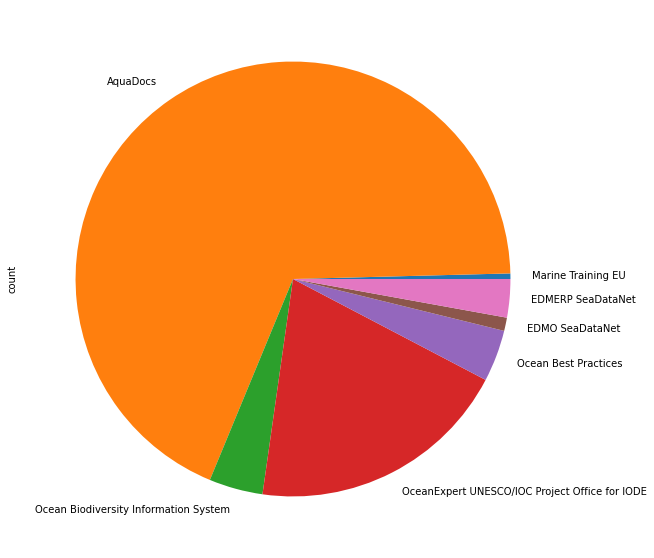

In [21]:
plot = dfp.plot.pie(y='count',legend=False, figsize=(10, 10))

In [22]:
rq_provdate = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

 
       SELECT   ( COUNT(?s) as ?count) ?time ?orgname  
        WHERE
        {
           ?s a prov:Activity  .
           ?s prov:endedAtTime ?time .
           ?s prov:generated ?gen .
           ?s prov:used ?used .
           ?used prov:hadMember ?mem .
           ?mem prov:wasAttributedTo ?wat .
           ?wat rdf:name ?orgname .
           ?wat rdfs:seeAlso ?domain
        }
        GROUP BY ?time ?orgname  
        """

dfpd = get_sparql_dataframe(oihdev, rq_provdate)

In [23]:
dfpd.head(10)

,count,time,orgname
0,626,2021-09-25T00:00:00.000Z,Marine Training EU
1,626,2021-10-18T00:00:00.000Z,Marine Training EU
2,624,2021-11-23T00:00:00.000Z,Marine Training EU
3,1,2021-11-28T00:00:00.000Z,AquaDocs
4,1,2021-09-25T00:00:00.000Z,AquaDocs
5,7527,2021-09-25T00:00:00.000Z,Ocean Biodiversity Information System
6,7547,2021-10-18T00:00:00.000Z,Ocean Biodiversity Information System
7,6659,2021-11-23T00:00:00.000Z,Ocean Biodiversity Information System
8,56902,2021-09-25T00:00:00.000Z,OceanExpert UNESCO/IOC Project Office for IODE
9,13641,2021-10-18T00:00:00.000Z,OceanExpert UNESCO/IOC Project Office for IODE


In [24]:
dfpd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   count    16 non-null     object
 1   time     16 non-null     object
 2   orgname  16 non-null     object
dtypes: object(3)
memory usage: 512.0+ bytes


In [25]:
# dfpd = get_sparql_dataframe(oihdev, rq_provdate)
dfpd['count'] = dfpd["count"].astype(int) # convert count c to int
dfpd['time'] = pd.to_datetime(dfpd['time'])
dftime = dfpd.sort_values(by='time') 
# dfpd['time'] = dfpd['time'].astype('datetime64[ns]')
# dfpd.set_index('time', inplace=True)


In [26]:
dftime.set_index('time', inplace=True)

dftime.head(20)


,count,orgname
time,,
2021-09-25 00:00:00+00:00,626,Marine Training EU
2021-09-25 00:00:00+00:00,1,AquaDocs
2021-09-25 00:00:00+00:00,7527,Ocean Biodiversity Information System
2021-09-25 00:00:00+00:00,56902,OceanExpert UNESCO/IOC Project Office for IODE
2021-09-25 00:00:00+00:00,1,Ocean Best Practices
2021-10-18 00:00:00+00:00,626,Marine Training EU
2021-10-18 00:00:00+00:00,7547,Ocean Biodiversity Information System
2021-10-18 00:00:00+00:00,13641,OceanExpert UNESCO/IOC Project Office for IODE
2021-10-19 00:00:00+00:00,43586,OceanExpert UNESCO/IOC Project Office for IODE


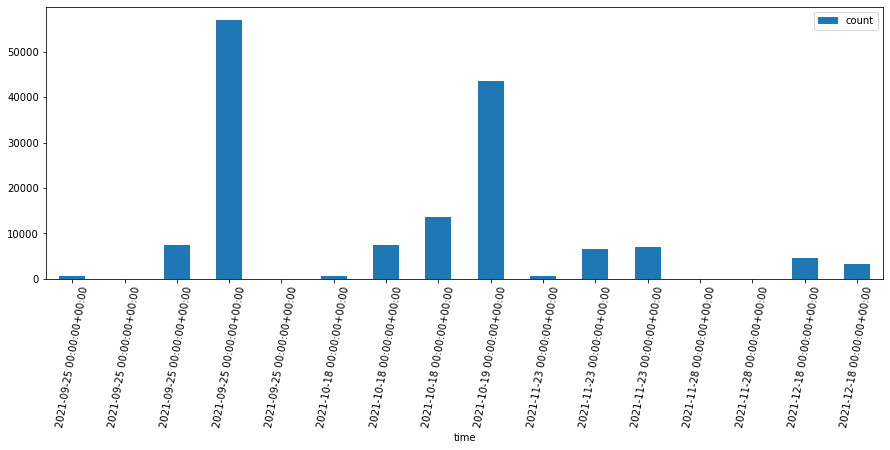

In [27]:
ax = dftime.plot.bar(rot=80, stacked=True, figsize=(15, 5))

## Feed query

Goal here is see if the prov will give us the elements for an RSS feed.  
The [RSS specs](https://validator.w3.org/feed/docs/rss2.html) give us the elements we need to populate.  Focus on; title(name), date, author, description

A recent example from gov at https://www.govinfo.gov/feeds

Since this could be very large injest, do it by the ingest events above instead?

* Element 	Description 	Example
* title 	The title of the item. 	Venice Film Festival Tries to Quit Sinking
* link 	The URL of the item. 	http://www.nytimes.com/2002/09/07/movies/07FEST.html
* description 	The item synopsis. 	Some of the most heated chatter at the Venice Film Festival this week was about the way that the arrival of the stars at the Palazzo del Cinema was being staged.
* author 	Email address of the author of the item. More. 	oprah@oxygen.net
* category 	Includes the item in one or more categories. More. 	Simpsons Characters
* comments 	URL of a page for comments relating to the item. More. 	http://www.myblog.org/cgi-local/mt/mt-comments.cgi?entry_id=290
* enclosure 	Describes a media object that is attached to the item. More. 	<enclosure url="http://live.curry.com/mp3/celebritySCms.mp3" length="1069871" type="audio/mpeg"/>
* guid 	A string that uniquely identifies the item. More. 	<guid isPermaLink="true">http://inessential.com/2002/09/01.php#a2</guid>
* pubDate 	Indicates when the item was published. More. 	Sun, 19 May 2002 15:21:36 GMT
* source 	The RSS channel that the item came from. More. 	<source url="http://www.quotationspage.com/data/qotd.rss">Quotes of the Day</source>

In [28]:
rq_provdatelist = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

       SELECT  ?time ?orgname ?memval  ?memname ?memdesc
        WHERE
        {
           ?s prov:endedAtTime ?time .
           ?s prov:generated ?gen .
           ?s prov:used ?used .
           ?used prov:hadMember ?mem .
           ?mem prov:value ?memval .
           ?mem schema:name ?memname .
           ?mem schema:description ?memdesc .
           ?mem prov:wasAttributedTo ?wat .
           ?wat rdf:name ?orgname .
        }
        ORDER BY DESC(?time) ASC(?memname)
        LIMIT 1000

        """

         #            ?s a prov:Activity  .

         #   ?wat rdfs:seeAlso ?domain

In [29]:
%%time
dfpl = get_sparql_dataframe(oihdev, rq_provdatelist)
dfpl.head(10)

CPU times: user 15.3 ms, sys: 4.94 ms, total: 20.2 ms
Wall time: 8.66 s


,time,orgname,memval,memname,memdesc
0,2021-12-18T00:00:00.000Z,EDMERP SeaDataNet,https://edmerp.seadatanet.org/report/11405,'Akvanavt-98',Study of the hydro-physical characteristics of...
1,2021-12-18T00:00:00.000Z,EDMERP SeaDataNet,https://edmerp.seadatanet.org/report/11406,'Akvanavt-98-RF',Study of the hydrologic structure in Russian s...
2,2021-12-18T00:00:00.000Z,EDMERP SeaDataNet,https://edmerp.seadatanet.org/report/11410,'Akvanavt-99-m',Method preparation and experimental works on s...
3,2021-12-18T00:00:00.000Z,EDMERP SeaDataNet,https://edmerp.seadatanet.org/report/11407,'Djubga',Study of the seismic and seismic-acoustic bott...
4,2021-12-18T00:00:00.000Z,EDMERP SeaDataNet,https://edmerp.seadatanet.org/report/11414,'Integrated optical-hydro-lithodynamics inves...,Integrated optical-hydro-lithodynamics investi...
5,2021-12-18T00:00:00.000Z,EDMERP SeaDataNet,https://edmerp.seadatanet.org/report/11408,'Neftyanik',Carrying out of the hydrographical survey by t...
6,2021-12-18T00:00:00.000Z,EDMERP SeaDataNet,https://edmerp.seadatanet.org/report/11415,'Turbidimetr -2000',"Research, development and making of the suspen..."
7,2021-12-18T00:00:00.000Z,EDMERP SeaDataNet,https://edmerp.seadatanet.org/report/11273,(CIPS/ICWB) SEA - an extensive multidisciplina...,"ï¿½Project Sea"" was the first major programme ..."
8,2021-12-18T00:00:00.000Z,EDMO SeaDataNet,https://edmo.seadatanet.org/report/4141,(Inland Fisheries Ireland) Cullion Fish Farm,Inland Fisheries Ireland trout fish farm opera...
9,2021-12-18T00:00:00.000Z,EDMERP SeaDataNet,https://edmerp.seadatanet.org/report/10405,18 EXPEDITION 'ASSESSMENT OF CONTAMINATION OF ...,Aims of the expedition included also carrying ...


## Keywords

In [27]:
rq_keywords = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

       SELECT   ( COUNT(?kw) as ?count) ?kw   
        WHERE
        {
           ?s schema:keywords ?kw
        }
        GROUP BY ?kw  
        ORDER BY DESC(?count)
        """


In [28]:
dfkw = get_sparql_dataframe(oihdev, rq_keywords)
dfkw['count'] = dfkw["count"].astype(int) # convert count c to int
dfkw.set_index('kw', inplace=True)
dfkw.head(10)

,count
kw,
Fisheries,43873
Biology,20834
Aquaculture,11790
Ecology,10524
GCFI,8856
Iran,8382
Management,7809
Occurrence,6825
Observation,5317


In [31]:
dfkw.to_csv('keywords.csv', index=False)

## Types Breakdown


In [30]:
rq_types = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

 
       SELECT   ( COUNT(?type) as ?count) ?type   
        WHERE
        {
        
           ?s rdf:type ?type
           FILTER ( ?type IN (schema:ResearchProject, schema:Project, schema:Organization, schema:Dataset, schema:CreativeWork, schema:Person, schema:Map, schema:Course, schema:CourseInstance, schema:Event, schema:Vehicle) )

        }
        GROUP BY ?type  
        ORDER BY DESC(?count)
        """




In [31]:
dft = get_sparql_dataframe(oihdev, rq_types)
dft['count'] = dft["count"].astype(int) # convert count c to int
dft.set_index('type', inplace=True)
dft.head(10)

,count
type,
https://schema.org/Person,344358
https://schema.org/Organization,86400
https://schema.org/CreativeWork,40856
https://schema.org/Event,40393
https://schema.org/Dataset,8509
https://schema.org/ResearchProject,3354
https://schema.org/CourseInstance,1651
https://schema.org/Course,830


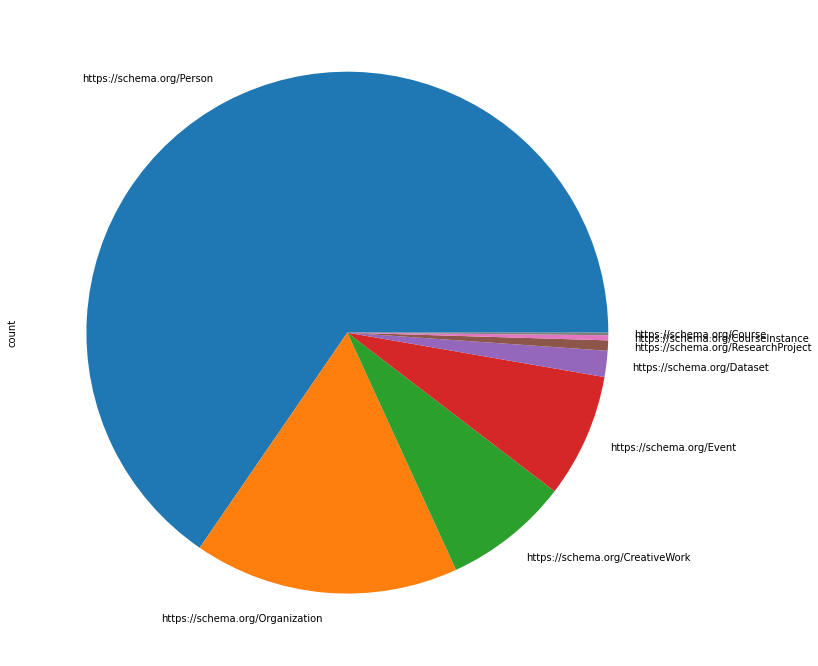

In [32]:
plot_t = dft.plot.pie(y='count',legend=False, figsize=(12, 12))

In [33]:
rq_typesCHECK = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

 
       SELECT  ( COUNT(?type) as ?count) ?type   
        WHERE
         {
           graph ?g {
            ?s ?p ?lit .
            ?s rdf:type ?type . 
            OPTIONAL { ?s schema:name ?name .   }
            OPTIONAL { ?s schema:headline ?headline .   }
            OPTIONAL { ?s schema:url ?url .   }
            OPTIONAL { ?s schema:description ?description .    }
          }
           ?sp prov:generated ?g  .
           ?sp prov:used ?used .
           ?used prov:hadMember ?hm .
           ?hm prov:wasAttributedTo ?wat .
           ?wat rdf:name "Ocean Biodiversity Information System" .
        }
        GROUP BY ?type  
         ORDER BY DESC(?count)
   
        """

#      GROUP BY ?type  
#         ORDER BY DESC(?count)

#  ( COUNT(?type) as ?count) ?type   

In [34]:
dft = get_sparql_dataframe(oihdev, rq_typesCHECK)
# dft['count'] = dft["count"].astype(int) # convert count c to int
# dft.set_index('type', inplace=True)
dft.head(10)

,count,type
0,146428,https://schema.org/Dataset
1,39124,https://schema.org/Organization
2,27493,https://schema.org/PropertyValue
3,24867,https://schema.org/DataDownload
4,22089,https://schema.org/Place
5,17018,https://schema.org/DataCatalog
6,14726,https://schema.org/GeoShape


## Check status of spatial predicates

We have 3500+ items with spatial data using the scheme.org vocabulary.   No current data published using the geosparql WKT patterns.  

In [35]:
rq_wktcount = """SELECT (COUNT(?s) as ?sCount)
WHERE
{
  {
  ?s <http://www.opengis.net/ont/geosparql#hasGeometry> ?o .
}
UNION
{
  ?s <https://schema.org/spatialCoverage> ?o
  }
}
"""

In [36]:
dfwc = get_sparql_dataframe(oihdev, rq_wktcount)
dfwc['sCount'] = dfwc["sCount"].astype(int) # convert count to int
# dfc.set_index('p', inplace=True)

In [37]:
dfwc.head()

,sCount
0,7363


In [46]:
rq_dups = """
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

 
       SELECT   ( COUNT(?name) as ?count) ?name   
        WHERE
        {
          ?s rdf:type ?type
           FILTER ( ?type IN ( schema:Dataset, schema:CreativeWork) )
           ?s schema:name ?name

        }
        GROUP BY ?name  
        HAVING (?count > 1)
        ORDER BY DESC(?count)
        """


dfdp = get_sparql_dataframe(oihdev, rq_dups)
dfdp['count'] = dfdp["count"].astype(int) # convert count c to int
dfdp.set_index('name', inplace=True)
dfdp.info()
dfdp.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 6372 entries,  to Harpacticoida from an intertidal flat in the Chernaya River estuary (White Sea)
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   count   6372 non-null   int64
dtypes: int64(1)
memory usage: 99.6+ KB


,count
name,
,381
News from Academy Bay,22
"Roundup: news, events, briefings and more",10
Introduction,9
"Discussion, biological session",5
Determination of effective parameters on growth and bloom forming of Cochlodinium polykrikoides,5
"Effects of aflatoxin B1 on growth performance, health indices, phagocytic activity and histopathological alteration in Fenneropenaeus indicus",4
"Isolation, identification and phylogenetic analysis of a pathogen of Haliotis diversicolor supertexta (L.) with mass mortalities",4
Study of possibilities of aquaculture activities in the Gorgan Bay,4


In [47]:
prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

        SELECT DISTINCT ?s  ?name  
        WHERE
        {
           ?lit bds:search "A General formatting system for geo-referenced data" .
           ?lit bds:matchAllTerms "false" .

           graph ?g {
            ?s ?p ?lit .
            FILTER isIRI(?s)
             OPTIONAL { ?s schema:name ?name .   }
           }
        }
        GROUP BY    ?name ?s
        LIMIT 300
        OFFSET 0

SyntaxError: invalid syntax (3691748111.py, line 1)

## OIH Query "lens"

Exploring how sites like http://portete.invemar.org.co/chm#/table could leverage OIH. Searches like "acidification"  A popular return for that search is https://aquadocs.org/handle/1834/9819 which is found in the OIH graph via [this search](https://oceans.collaborium.io/?search=Optimizaci%C3%B3n+de+los+procesos+de+ensilado+a+partir+de+residuos+de+la+industria+pesquera+y+evaluaci%C3%B3n+de+nuevas+aplicaciones+en+la+alimentaci%C3%B3n+animal.).

The thought is what would a search site do via the OIH graph that might be interesting.  We can think about looking for the types associated with a result and then seeing what the next level result would be.   



In [7]:
lens1 = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

        SELECT DISTINCT  ?t ?ttype ?name
        WHERE

        {
           ?s ?p "https://www.oceandocs.org/handle/1834/9819" .
           ?s ?pp ?t .
           ?t a ?ttype .
           ?t schema:name ?name
  
  }
  """

dflens1 = get_sparql_dataframe(oihdev, lens1)
dflens1.head(10)

,t,ttype,name
0,t231465,https://schema.org/Organization,Universidad Nacional del Comahue. Centro Regio...
1,t366674,https://schema.org/Person,"GÃ³ngora, HernÃ¡n G."


In [8]:
lens2 = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

        SELECT DISTINCT  ?us ?up ?ao ?uus ?uup
        WHERE

        {
           ?s ?p "https://www.oceandocs.org/handle/1834/9819" .
              ?s <https://schema.org/author> ?auth .
              ?auth <https://schema.org/name> ?ao .
 
              ?us ?up ?ao .
              ?uus ?uo ?us
  
  }
  """

dflens1 = get_sparql_dataframe(oihdev, lens2)
dflens1.head(10)

,us,up,ao,uus,uup
0,t366674,https://schema.org/name,"GÃ³ngora, HernÃ¡n G.",oai:aquadocs.org:1834/9819,None


In [11]:
lens3 = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

 
       SELECT ?itemp ?itemo
        WHERE
        {
        
           ?s rdf:type 	<https://schema.org/Vehicle> .
            ?s 	<https://schema.org/itemListElement> ?le .
                ?le ?lep ?item .
           ?item ?itemp ?itemo
        }
 
  """

dflens1 = get_sparql_dataframe(oihinvemar, lens3)
dflens1.head(10)

,itemp,itemo
0,https://schema.org/url,
1,https://schema.org/description,Barco de investigaci��n oceanogr��fica de clas...
2,https://schema.org/description,Barco de investigaciÃ³n oceanogrÃ¡fica de clas...
3,https://schema.org/category,Oceanic
4,https://schema.org/vehicleConfiguration,"Radar (2), Loran, Gyro, GPS (3), SPS-73 Surfac..."
5,https://schema.org/vehicleSpecialUsage,Research
6,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,https://schema.org/Vehicle
7,https://schema.org/name,RV Sally Ride (AGOR-28)
8,https://schema.org/url,
9,https://schema.org/description,Buque de investigaciÃ³n de clase Neil Armstron...
